# Example 4: Simple NPTF example

In this example we perform a non-Poissonian template fit in a simplified setting. Specifically we will restrict ourselves to randomly generated nside=2 maps, which means our data consists only of 48 pixels. Nevertheless in this simple setting we will be able to clearly see the difference between Poissonian and non-Poissonian statistics as well as basic features of how non-Poissonian template fitting is performed with the code.

Throughout this example we will assume there is no smearing of the counts coming from all point sources. The effect of a finite point spread function on the statistics and how to account for it is discussed in Example 5.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib import rcParams

from NPTFit import nptfit # module for performing scan
from NPTFit import dnds_analysis # module for analysing the output

from __future__ import print_function

## Example 1: A map without point sources

We start out by analyzing a map without any point sources, using a uniform exposure map. First let's create and plot our random data.

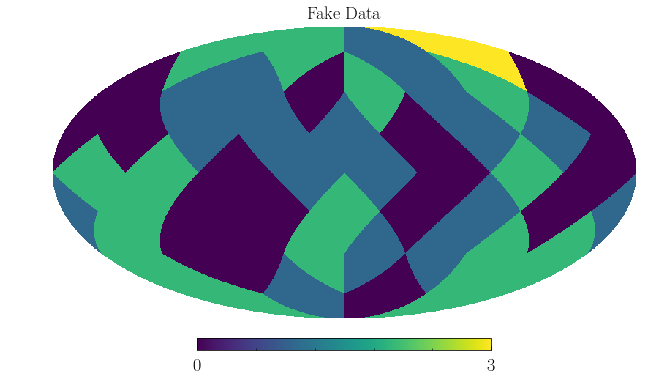

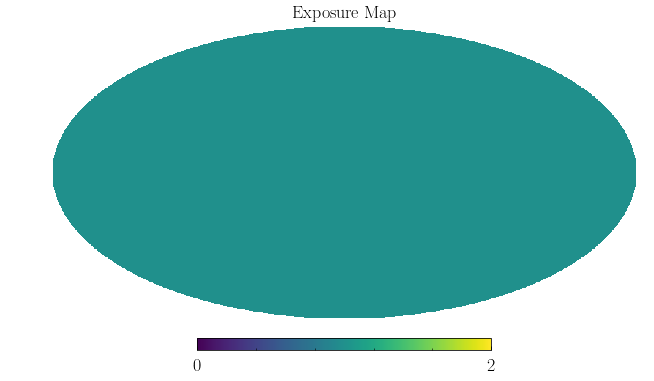

In [2]:
nside = 2
npix = hp.nside2npix(nside)
data = np.random.poisson(1,npix)
exposure = np.ones(npix)

hp.mollview(data,title='Fake Data')
hp.mollview(exposure,title='Exposure Map')

Next we set up an instance of NPTFit and add in the data. We'll analyze the entire sky at once, so we won't add in a mask.

In [3]:
n = nptfit.NPTF(tag='SimpleNPTF_Example')
n.load_data(data, exposure)

Now we add in templates, one to describe isotropic Poissonian emission and one for isotropic point sources. Note the different syntax requires for each.

In [4]:
iso = np.ones(npix)
n.add_template(iso, 'iso_p', units='flux')
n.add_template(iso, 'iso_np', units='PS')

We add in both models, being careful to select the right template. Here we model the PS point spread function as a singly broken power law, which requires four parameters to describe it: the normalization A, the indices above and below the breaks n1 and n2, and the location of the break Sb.

More details on the forms for the non-Poissonian model can be found in Example 6.

In [5]:
n.add_poiss_model('iso_p', '$A_\mathrm{iso}$', [0,2], False)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-10,1],[2.05,60],[-60,1.95],[0.01,200]],
                      [True,False,False,False])

Once everything is setup, we configure and perform the scan, and then show the triangle plot and flux fraction plot.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 5
  analysing data from /group/hepheno/smsharma/NPTFit/examples/chains/SimpleNPTF_Example/.txt


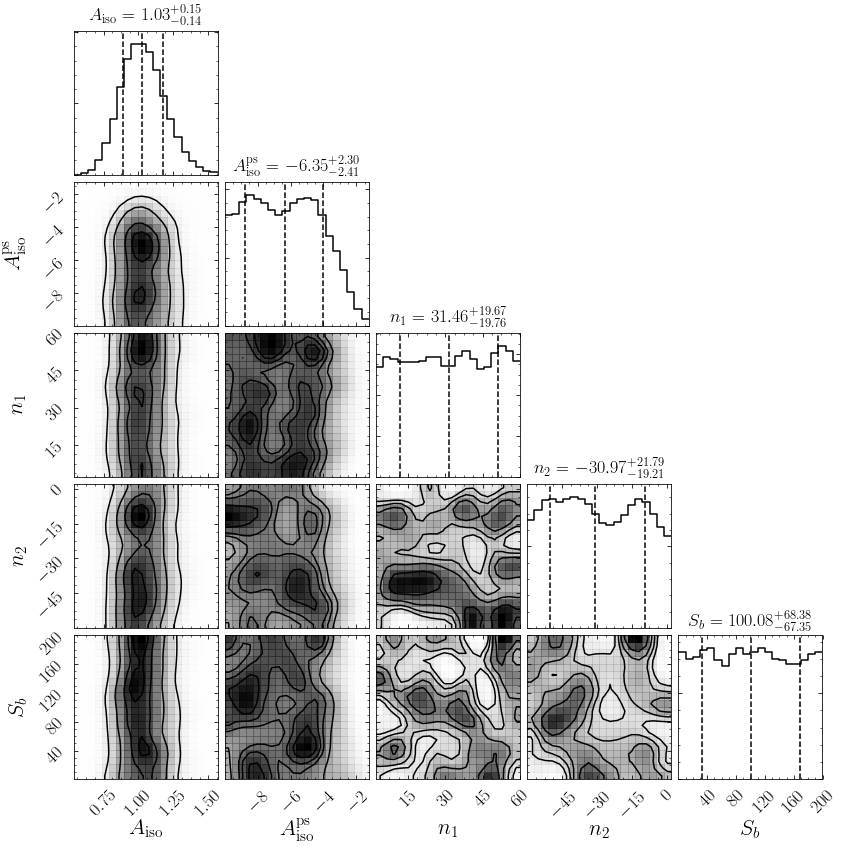

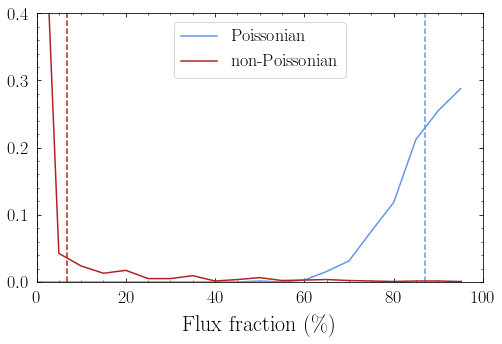

In [6]:
n.configure_for_scan()
n.perform_scan(nlive=500)

n.load_scan()
an = dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

an.plot_intensity_fraction_poiss('iso_p', bins=20, color='cornflowerblue', label='Poissonian')
an.plot_intensity_fraction_non_poiss('iso_np', bins=20, color='firebrick', label='non-Poissonian')
plt.xlabel('Flux fraction (\%)')
plt.legend(fancybox = True)
plt.xlim(0,100);
plt.ylim(0,0.4);

We see that the Poissonian template has absorbed essentially everything, whilst the non-Poissonian parameters are poorly converged - expected as there were no point sources injected.

## Example 2: A map with point sources

We now repeat the analysis above, but now add in 10 mean 50 count point sources. First lets take the data from above and add the point sources.

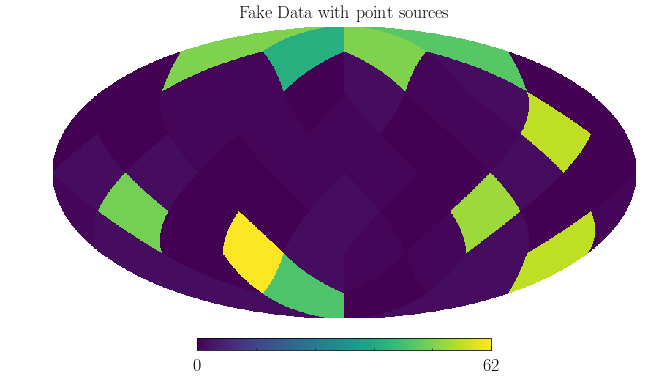

In [7]:
for ips in range(10):
    data[np.random.randint(npix)] += np.random.poisson(50)

hp.mollview(data,title='Fake Data with point sources')

Now we repeat all the steps used in the example without point sources.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 5
  analysing data from /group/hepheno/smsharma/NPTFit/examples/chains/SimpleNPTF_Example/.txt


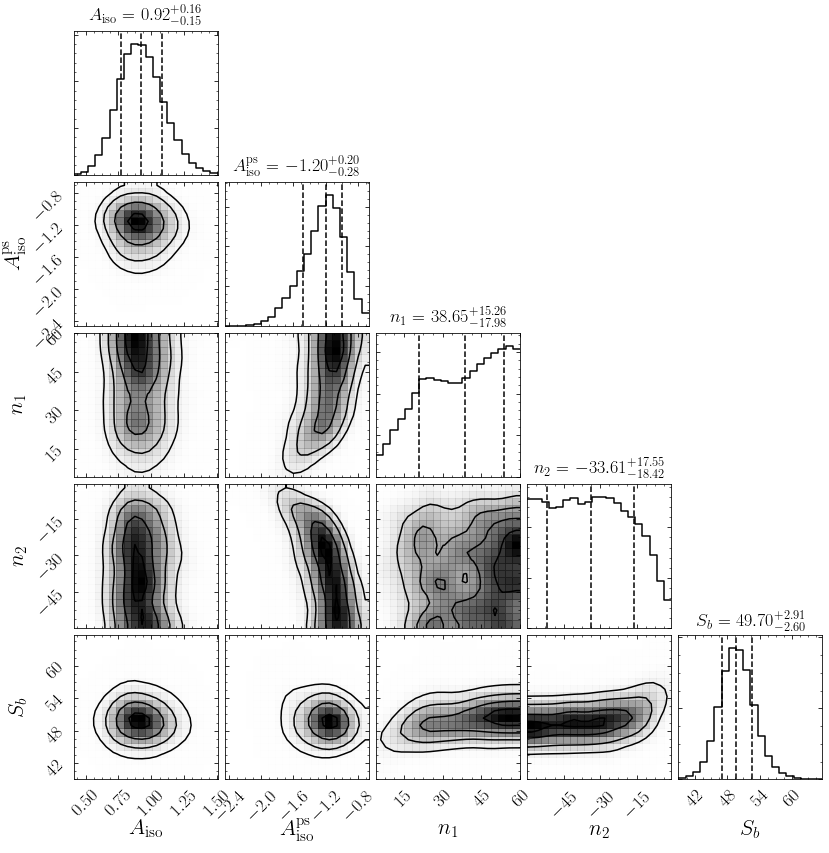

In [8]:
n = nptfit.NPTF(tag='SimpleNPTF_Example')
n.load_data(data,exposure)

iso = np.ones(npix)
n.add_template(iso, 'iso_p',units='flux')
n.add_template(iso, 'iso_np',units='PS')

n.add_poiss_model('iso_p', '$A_\mathrm{iso}$', [0,2], False)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-10,1],[2.05,60],[-60,1.95],[0.01,200]],
                      [True,False,False,False])

n.configure_for_scan()
n.perform_scan(nlive=500)

n.load_scan()
an = dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

We now see that both the Poissonian and non-Poissonian parameters are quite well converged. Note that the indices both want to have a large magnitude, which makes sense as we have effectively injected a delta function in flux, and the singly broken power law is trying to mimic that. Note that Sb is well converged near 50 counts per source, which is what we injected.

## Example 3: A map with point sources and non-uniform exposure map

We will now repeat the above exercise but on a map without uniform exposure. This will highlight the importance of exposure regions.

To begin with let's again create the data, but now we pretend that one side of the sky is expected to obtain twice as many counts as the other (which could occur if the instrument looked at that half of the sky twice as long for example).

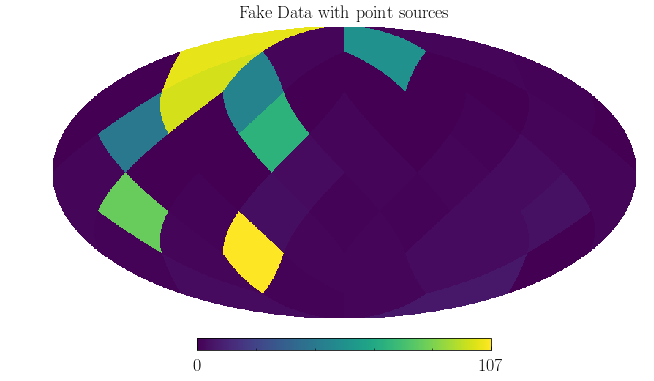

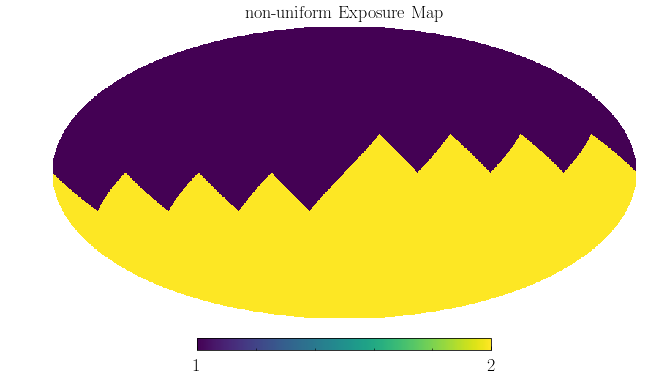

In [9]:
nside = 2
npix = hp.nside2npix(nside)
exposure = np.zeros(npix)
exposure[0:npix/2] = 1.0
exposure[npix/2:npix] = 2.0
data = np.random.poisson(exposure)

for ips in range(10):
    loc = np.random.randint(npix)
    data[loc] += np.random.poisson(50*exposure[loc])

hp.mollview(data,title='Fake Data with point sources')
hp.mollview(exposure,title='non-uniform Exposure Map')

Now we again analyze this data. Critically, note that when we configure the scan we set nexp=2 to indicate that the code should run with 2 exposure regions. In this simple example we know that 2 is all we need, but in real situations it is worth trying various values of nexp to see where results converge.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 5
  analysing data from /group/hepheno/smsharma/NPTFit/examples/chains/SimpleNPTF_Example/.txt


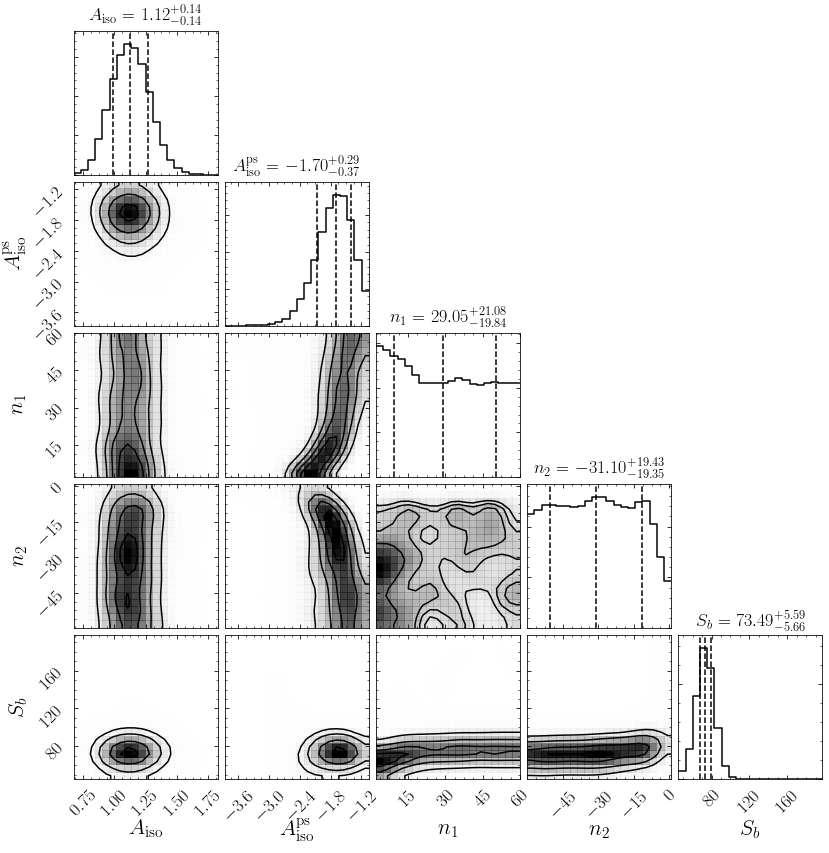

In [10]:
n = nptfit.NPTF(tag='SimpleNPTF_Example')
n.load_data(data,exposure)

iso = np.ones(npix)
n.add_template(iso, 'iso_p',units='flux')
n.add_template(iso, 'iso_np',units='PS')

n.add_poiss_model('iso_p', '$A_\mathrm{iso}$', [0,2], False)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-10,1],[2.05,60],[-60,1.95],[0.01,200]],
                      [True,False,False,False])

n.configure_for_scan(nexp=2)
n.perform_scan(nlive=500)

n.load_scan()
an = dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

Everything is again well converged. Note that this time Sb has converged near 75, not 50. This is exactly what should be expected though, as the mean number of injected counts per PS over the sky is 50 x mean(exposure) = 75.

To highlight the importance of the exposure regions, let's repeat this using only one exposure region which we emphasize is the **wrong** thing to do.

No mask set; defaulting to a blank mask
The number of parameters to be fit is 5
  analysing data from /group/hepheno/smsharma/NPTFit/examples/chains/SimpleNPTF_Example/.txt


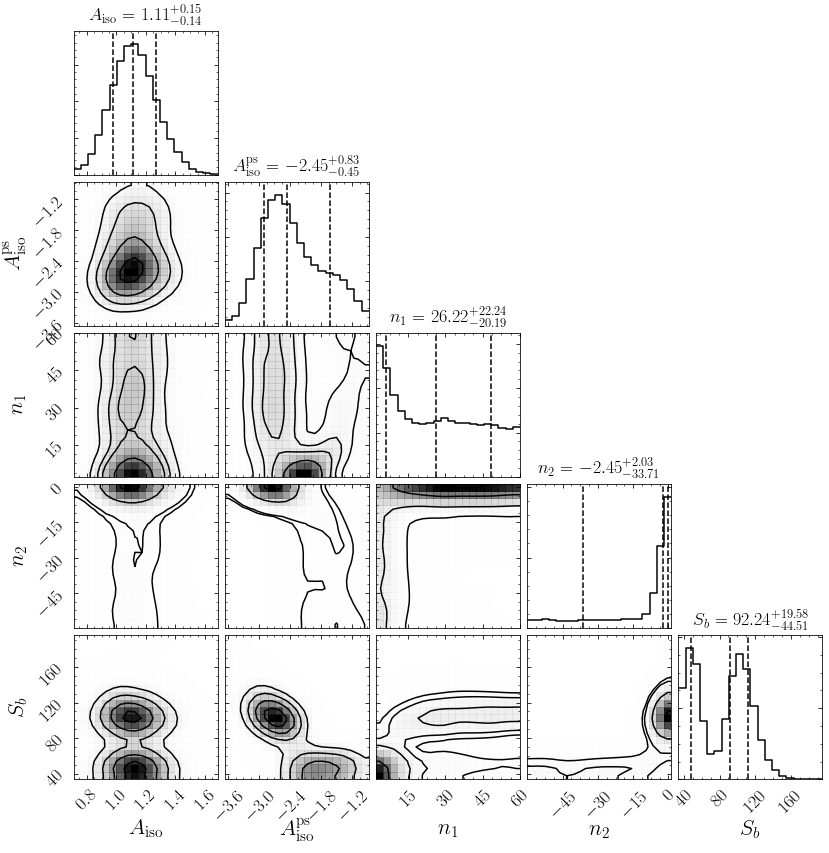

In [11]:
n = nptfit.NPTF(tag='SimpleNPTF_Example')
n.load_data(data,exposure)

iso = np.ones(npix)
n.add_template(iso, 'iso_p',units='flux')
n.add_template(iso, 'iso_np',units='PS')

n.add_poiss_model('iso_p', '$A_\mathrm{iso}$', [0,2], False)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-10,1],[2.05,60],[-60,1.95],[0.01,200]],
                      [True,False,False,False])

n.configure_for_scan(nexp=1)
n.perform_scan(nlive=500)

n.load_scan()
an = dnds_analysis.Analysis(n)
an.make_triangle()
plt.show()
plt.close()

We see that the non-Poissonian parameters are not as well converged, and in particular Sb has not converged to its mean value over the sky. Note that Sb appears in some instance to be bimodal, at 50 and 100 representing the two point source brightnesses if the exposure correction is not accounted for.